# Create photoreduction forcing files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import netCDF4 as nc
import xarray as xr
import pickle

%matplotlib inline

Photo-enhanced reduction should occur over the euphotic zone depth. For the Canada Basin, Laney et al. (2017) estimated the euphotic zone depth as ~70-110 m based on the 1% light extinction from ITP measurements. Bhatia et al. (2021) estimated the euphotic zone depth in the CAA with a median of 50 m. If I apply the euphotic zone depth of ~56 m (depth level < 20) over the entire region, that would be a coarse estimate. Alternatively, I could have a gradual transition from the CB to CAA.

In [3]:
imin, imax = 1099, 2179
jmin, jmax = 159, 799

isize = imax-imin
jsize = jmax-jmin

##### Load files

In [4]:
mesh  = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask = np.array(mesh.variables['tmask'])
land_mask = np.ma.masked_where((tmask[0,:,:,:] > 0.1), tmask[0,:,:,:])
lons  = np.array(mesh.variables['nav_lon'])
lats  = np.array(mesh.variables['nav_lat'])
mbathy = np.array(mesh.variables['mbathy'])[0,:,:] # bottom depth

Define euphotic zone depth:

In [5]:
euphotic_depth = np.zeros(lons.shape)
euphotic_depth[:] = 70
euphotic_depth[(mbathy == 43)] = 65
euphotic_depth[(mbathy == 42)] = 60
euphotic_depth[(mbathy == 41)] = 55
euphotic_depth[mbathy <= 40] = 50 # depth level mbathy = 509

##### Calculations

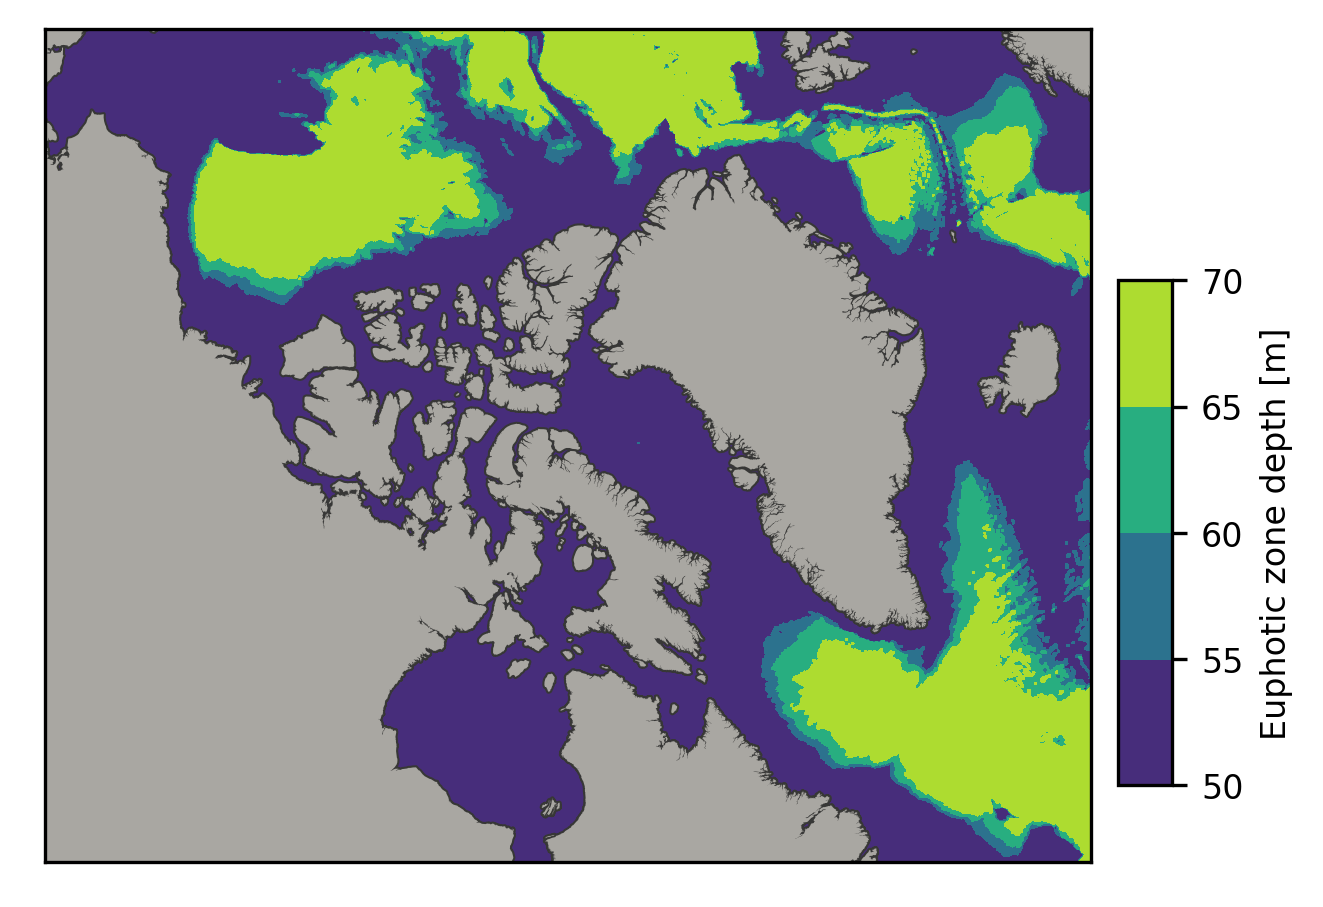

In [8]:
fig, ax1, proj1= pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/pb-surface.pickle','rb'))

x, y = proj1(lons, lats) 

# Euphotic zone depth:
CB = proj1.contourf(x, y, euphotic_depth, vmin=50, vmax=70, levels=[50,55,60,65,70])

cbaxes = fig.add_axes([0.92, 0.2, 0.04, 0.45])
CBar   = plt.colorbar(CB, cax=cbaxes)
CBar.set_label(label='Euphotic zone depth [m]',size=8)
CBar.ax.tick_params(labelsize=8)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper3-202110/A13-euphotic-depth.png',bbox_inches='tight', dpi=300)

Save file:

In [9]:
file_write = xr.Dataset(
    {'euphotic': (("y","x"), euphotic_depth)}, 
    coords = {
        "y": np.zeros(2400),
        "x": np.zeros(1632),
    },
    attrs = {
        'long_name':'Euphotic zone depth',
        'units':'m',
    }
)

file_write.to_netcdf('/ocean/brogalla/GEOTRACES/data/euphotic-pb-scavenging.nc')